# CS230 Project: Adversarial Face Recognition + Defense

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shutil
import os
import time
from collections import defaultdict
from PIL import Image
from matplotlib.pyplot import imsave

import facenet
import lfw
import foolbox

## Data loading

In [2]:
# Based on https://github.com/tensorflow/cleverhans/tree/master/examples/facenet_adversarial_faces

pairs_path = "../data/pairs.txt"
testset_path = "../data/lfw/lfw_mtcnnpy_160"
image_size = 160

def load_testset(size):
  # Load images paths and labels
  pairs = lfw.read_pairs(pairs_path)
  paths, labels = lfw.get_paths(testset_path, pairs)

  # Random choice
  np.random.seed(0)
  permutation = np.random.choice(len(labels), size, replace=False)
  paths_batch_1 = []
  paths_batch_2 = []

  for index in permutation:
    paths_batch_1.append(paths[index * 2])
    paths_batch_2.append(paths[index * 2 + 1])

  labels = np.asarray(labels)[permutation]
  paths_batch_1 = np.asarray(paths_batch_1)
  paths_batch_2 = np.asarray(paths_batch_2)

  # Load images
  faces1 = facenet.load_data(paths_batch_1, False, False, image_size)
  faces2 = facenet.load_data(paths_batch_2, False, False, image_size)

  # Change pixel values to 0 to 1 values
  min_pixel = min(np.min(faces1), np.min(faces2))
  max_pixel = max(np.max(faces1), np.max(faces2))
  faces1 = (faces1 - min_pixel) / (max_pixel - min_pixel)
  faces2 = (faces2 - min_pixel) / (max_pixel - min_pixel)

  # Convert labels to one-hot vectors
  onehot_labels = []
  for index in range(len(labels)):
    if labels[index]:
      onehot_labels.append([1, 0])
    else:
      onehot_labels.append([0, 1])

  return faces1, faces2, np.array(onehot_labels)

## FaceNet model configuraiton

In [3]:
# Based on https://github.com/tensorflow/cleverhans/tree/master/examples/facenet_adversarial_faces

class InceptionResnetV1Model():
  model_path = "../models/20180402-114759/20180402-114759.pb"

  def __init__(self):
    # Load Facenet CNN
    facenet.load_model(self.model_path)
    # Save input and output tensors references
    graph = tf.get_default_graph()
    self.face_input = graph.get_tensor_by_name("input:0")
    self.embedding_output = graph.get_tensor_by_name("embeddings:0")

  def convert_to_classifier(self):
    # Create victim_embedding placeholder
    self.victim_embedding_input = tf.placeholder(
        tf.float32,
        shape=(None, 512))

    # Squared Euclidean Distance between embeddings
    self.distance = tf.reduce_sum(
        tf.square(self.embedding_output - self.victim_embedding_input),
        axis=1)

    # Convert distance to a softmax vector
    # 0.99 out of 4 is the distance threshold for the Facenet CNN
    threshold = 0.99
    score = tf.where(
        self.distance > threshold,
        0.5 + ((self.distance - threshold) * 0.5) / (4.0 - threshold),
        0.5 * self.distance / threshold)
    reverse_score = 1.0 - score
    self.softmax_output = tf.transpose(tf.stack([reverse_score, score]))

    # Save softmax layer
    self.layer_names = []
    self.layers = []
    self.layers.append(self.softmax_output)
    self.layer_names.append('logits')

  def convert_to_targeted_classifier(self, victim):
    # Create victim_embedding placeholder
    self.victim_embedding_input = tf.constant(
        victim,
        shape=(1, 512))

    # Squared Euclidean Distance between embeddings
    self.distance = tf.reduce_sum(
        tf.square(self.embedding_output - self.victim_embedding_input),
        axis=1)

    # Convert distance to a softmax vector
    # 0.99 out of 4 is the distance threshold for the Facenet CNN
    threshold = 0.99
    score = tf.where(
        self.distance > threshold,
        0.5 + ((self.distance - threshold) * 0.5) / (4.0 - threshold),
        0.5 * self.distance / threshold)
    reverse_score = 1.0 - score

    self.softmax_output = tf.transpose(tf.stack([reverse_score, score]))

    # Foolbox expects logits
    self.logits = tf.log(self.softmax_output)

    # Save softmax layer
    self.layer_names = []
    self.layers = []
    self.layers.append(self.logits)
    self.layer_names.append('logits')

  def fprop(self, x, set_ref=False):
    return dict(zip(self.layer_names, self.layers))

## Exmple attack

In [4]:
# LFW test set is pairs (face1, face2)
# You need to output same or not same

# Attack means if faces are of same person we want to perturb face1 such that 
# model outputs not same. On the other hand, if faces are not of same person we want
# to perturb face1 such that model outputs same. 

# Second face in each pair is fixed and we perturb the first. 

# Step 1: Derive embeddings of all face pairs through forward prop

tf.Graph().as_default()
sess = tf.Session()
# Load model
model = InceptionResnetV1Model()
# Convert to classifier
model.convert_to_classifier()

# Load pairs of faces and their labels in one-hot encoding
size = 100
faces1, faces2, labels = load_testset(size)
binary_labels = [0 if labels[i][0] == 1 else 1 for i in range(size)]

# Create victims' embeddings using Facenet itself
graph = tf.get_default_graph()
phase_train_placeholder = graph.get_tensor_by_name("phase_train:0")
feed_dict = {model.face_input: faces2,
              phase_train_placeholder: False}
victims_embeddings = sess.run(
    model.embedding_output, feed_dict=feed_dict)
feed_dict = {model.face_input: faces1,
              phase_train_placeholder: False}
non_victims_embeddings = sess.run(
  model.embedding_output, feed_dict=feed_dict)

sess.close()

Model filename: ../models/20180402-114759/20180402-114759.pb
Instructions for updating:
Use tf.gfile.GFile.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Data Exploration

In [5]:
def visualize_lfw_pair(i, show_axis=True):
    plt.subplot(1, 2, 1)
    plt.imshow(faces1[i])
    if not show_axis:
        plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(faces2[i])
    if not show_axis:
        plt.axis('off')

    print("Same Person") if labels[i][0] == 1 else print("Different Person")

    distance = np.sum(np.square(victims_embeddings[i] - non_victims_embeddings[i]))
    print("Squared Euclidean Distance: ", distance, " (threshold=0.99)")

Same Person
Squared Euclidean Distance:  0.59405065  (threshold=0.99)


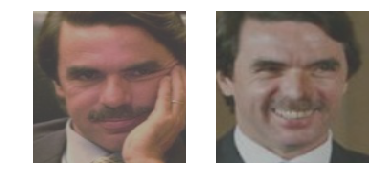

In [6]:
visualize_lfw_pair(0, False)

Different Person
Squared Euclidean Distance:  2.3449798  (threshold=0.99)


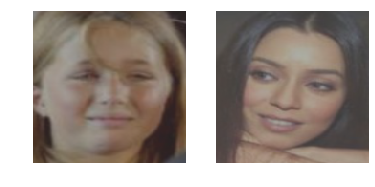

In [7]:
visualize_lfw_pair(3, False)

### Attack Similar Pair (i = 0)

In [8]:
graph = tf.get_default_graph()
i = 0
sess = tf.Session()
model = InceptionResnetV1Model()
model.convert_to_targeted_classifier(victims_embeddings[i])
model_fb = foolbox.models.TensorFlowModel(model.face_input, model.logits, (0, 1),
                                          {phase_train_placeholder: False})
phase_train_placeholder = graph.get_tensor_by_name("phase_train:0")

attack = foolbox.v1.attacks.FGSM(model_fb)
adversarial = attack(faces1[i:i+1][0], label=0)

Model filename: ../models/20180402-114759/20180402-114759.pb



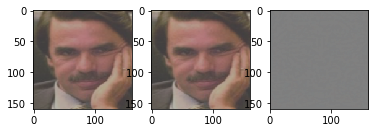

In [9]:
plt.subplot(1, 3, 1)
plt.imshow(faces1[i])

plt.subplot(1, 3, 2)
plt.imshow(adversarial)

plt.subplot(1, 3, 3)
plt.imshow(adversarial - faces1[i] + 0.5)

In [10]:
# Confirm this worked
# Remember class 0 is "same" and class 1 is "not same"
model_fb.forward(np.array([adversarial])).argmax(axis=-1)

array([1])

In [11]:
sess.close()

In [12]:
# How much of the face was changed
# squared euclidean distance (remember pixel values are scaled between 0-1 now)
np.linalg.norm(adversarial - faces1[i])

0.543863979408777

### Attack different pair

In [13]:
graph = tf.get_default_graph()
sess = tf.Session()

i = 3

model = InceptionResnetV1Model()
model.convert_to_targeted_classifier(victims_embeddings[i])
model_fb = foolbox.models.TensorFlowModel(model.face_input, model.logits, (0, 1),
                                          {phase_train_placeholder: False})
phase_train_placeholder = graph.get_tensor_by_name("phase_train:0")

attack = foolbox.v1.attacks.FGSM(model_fb)
adversarial = attack(faces1[i:i+1][0], label=1)

Model filename: ../models/20180402-114759/20180402-114759.pb


In [25]:
def simple_visualize_lfw_attack(i, adversarial, adversarial_embedding=None):
    title = "Same" if binary_labels[i] == 0 else "Different"
    title += ' Person, '
    distance = np.sum(np.square(victims_embeddings[i] - non_victims_embeddings[i]))
    title += "distance {0:0.3f}".format(distance)
    
    fig, axs = plt.subplots(1, 4)
    
    fig.suptitle(title, size=16)

    axs[0].imshow(faces1[i])
    axs[1].imshow(adversarial - faces1[i] + 0.5)
    axs[2].imshow(adversarial)
    axs[3].imshow(faces2[i])
    
    for i in range(4):
        axs[i].axis('off')

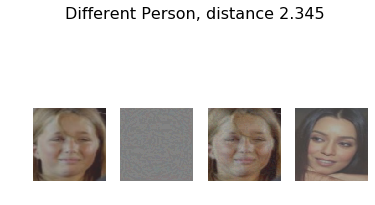

In [26]:
simple_visualize_lfw_attack(3, adversarial)

In [27]:
# Confirm this worked
# Remember class 0 is "same" and class 1 is "not same"
model_fb.forward(np.array([adversarial])).argmax(axis=-1)

array([0])

In [28]:
sess.close()

In [29]:
# How much of the face was changed
# squared euclidean distance (remember pixel values are scaled between 0-1 now)
np.linalg.norm(adversarial - faces1[i])

4.0789795606523995

## Experiments

In [30]:
attacks = {
    'fgsm': foolbox.v1.attacks.FGSM,
    'deep_fool': foolbox.v1.attacks.DeepFoolL2Attack,
    'guassian_noise': foolbox.v1.attacks.AdditiveGaussianNoiseAttack,
    'uniform_noise': foolbox.v1.attacks.AdditiveUniformNoiseAttack,  
}

In [16]:
def run_attack(i, attack_type):
    with tf.Session() as sess:
        graph = tf.get_default_graph()
        model = InceptionResnetV1Model()
        phase_train_placeholder = graph.get_tensor_by_name("phase_train:0")
        print("Starting to attack image ", i)
        model.convert_to_targeted_classifier(victims_embeddings[i])
        model_fb = foolbox.models.TensorFlowModel(model.face_input, model.logits, (0, 1),
                                              {phase_train_placeholder: False})

        attack = attack_type(model_fb)
        t0 = time.time()
        adversarial = attack(faces1[i:i+1][0], label=binary_labels[i])
        t1 = time.time()

        if adversarial is not None:
            diff = np.linalg.norm(adversarial - faces1[i])
        else:
            diff = None
        
        graph = tf.get_default_graph()
        model = InceptionResnetV1Model()
        phase_train_placeholder = graph.get_tensor_by_name("phase_train:0")
        model.convert_to_classifier()
        feed_dict = {model.face_input: [adversarial], phase_train_placeholder: False}
        adversarial_embedding = sess.run(model.embedding_output, feed_dict=feed_dict)[0]
        
        del attack
        del model_fb
        del phase_train_placeholder
        del model

    return {
        'diff': diff,
        'time': t1 - t0,
        'adversarial': adversarial,
        'adversarial_embedding': adversarial_embedding
    }

In [17]:
experiment_size = 50

def generate_data():    
    attack_to_data = {}
    for name, attack_type in attacks.items():
        changed = []
        times = []
        adversarials = []

        for i in range(experiment_size):
            res = run_attack(i, attack_type)

        attack_to_data[name] = {
            'changed': res['changed'],
            'times': res['time'],
            'adversarials': res['adversarial']
        }
    return attack_to_data

# attack_to_data = generate_data()

# save results to file
# with open('attack_results/attack_to_data', 'wb') as f:
#     pickle.dump(attack_to_data, f)
    
# load results
with open('attack_results/attack_to_data', 'rb') as f:
    attack_to_data = pickle.load(f)

In [18]:
def attack_accuracy(changed_array, threshold):
    return np.mean([(change is not None and change < threshold) for change in changed_array])

In [19]:
def find_examples_per_attack():
    attack_to_ind_labels = defaultdict(list)
    for i in range(experiment_size):
        all_good = False
        for name, data in attack_to_data.items():
            if data['changed'][i] is not None:
                attack_to_ind_labels[name].append((i, binary_labels[i]))

# find_examples_per_attack()

In [20]:
# picked using results from find_examples_per_attack
attack_to_inds = {
    'fgsm': [0, 3],
    'deep_fool': [9, 6],
    'guassian_noise': [2, 34],
    'uniform_noise': [4, 34],
}

In [21]:
def dist(i1, i2):
    return np.sum(np.square(i1 - i2))

In [22]:
def visualize_lfw_attack(attack_name, i, adversarial, adversarial_embedding, filename=None):
    vic_emb = victims_embeddings[i]
    non_vic_emb = non_victims_embeddings[i]
    adv_emb = adversarial_embedding
    
    orig_dist = dist(vic_emb, non_vic_emb)
    orig_same = binary_labels[i] == 0
    
    norm_change = np.linalg.norm(adversarial - faces1[i])
    
    thresh = 0.99
    adv_dist = dist(adv_emb, vic_emb)
    adv_same = adv_dist < thresh

    title = attack_name + ": "
    title += "Same" if orig_same else "Different"
    title += ' Person -> '
    title += "Same" if adv_same else "Different"
    title += "\nEmbedding dist {:0.3f} -> {:0.3f}".format(orig_dist, adv_dist)
    title += '\nNorm change {:0.3f}'.format(norm_change)
    
    fig, axs = plt.subplots(1, 4)
    
    fig.suptitle(title, size=16)

    axs[0].imshow(faces1[i])
    difference = adversarial - faces1[i]
    axs[1].imshow(difference / abs(difference).max() * 0.2 + 0.5)
    axs[2].imshow(adversarial)
    axs[3].imshow(faces2[i])
    for j in range(4):
        axs[j].axis('off')
        
    fig.subplots_adjust(top=1.08)

    if filename:
        plt.savefig(filename, dpi=300, bbox_inches = 'tight')

In [23]:
def make_attack_results():
    attack_results = {}
    for name, inds in attack_to_inds.items():
        attack_type = attacks[name]
        for ind in inds:
            attack_results[(name, ind)] = run_attack(ind, attack_type)
# attack_results = make_attack_results()

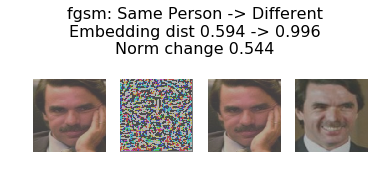

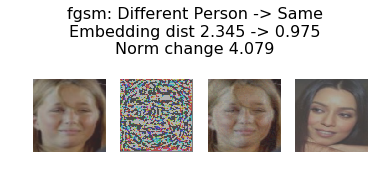

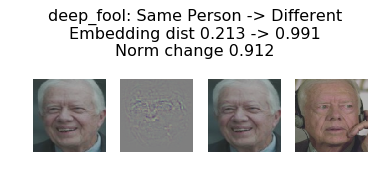

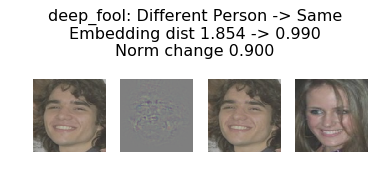

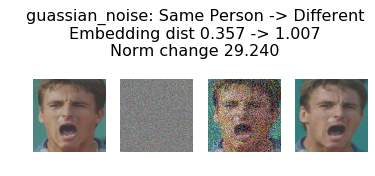

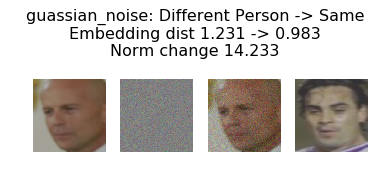

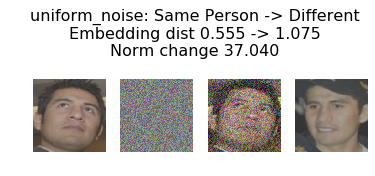

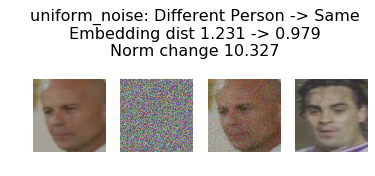

In [62]:
for (name, ind), result in attack_results.items():
    visualize_lfw_attack(name, ind, result['adversarial'], result['adversarial_embedding'], '{}_{}.png'.format(name, ind))

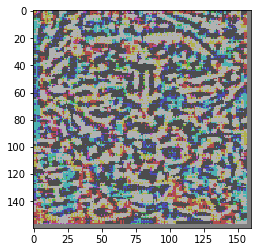

In [68]:
ind = 0
result = attack_results[('fgsm', 0)]
difference = result['adversarial'] - faces1[ind]
plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)

In [72]:
thresholds = np.logspace(-1, 2.5, num=30)
name_to_y = defaultdict(list)

for thresh in thresholds:
    for name, data in attack_to_data.items():
        name_to_y[name].append(attack_accuracy(data['changed'], thresh))

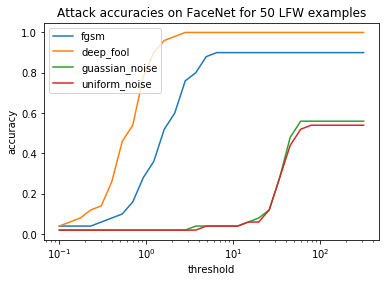

In [73]:
for name, ys in name_to_y.items():
    plt.plot(thresholds, ys, label=name)
plt.xscale('log')
plt.xlabel('threshold')
plt.ylabel('accuracy')
plt.title('Attack accuracies on FaceNet for 50 LFW examples')
plt.legend()
plt.savefig('attack_accuracies.png', dpi=300)